# Description

Humans train dogs by delivering rewards to specific actions so that the dog will associate certain actions and situations to either positive (to be repeated again) or negative (to be avoided) values. Similarly, artificial agents are now trained automatically by reinforcement signals delivered after a goal has been achieved by the agent. Unfortunately, this process is very slow and requires many samples to learn. The aim of this project is to test whether it is possible to train a character in a video-game by delivering the reward (mouse click) at any event of teacher's choice (not only at the end of a goal). What would the best strategy for delivering a limited number of rewards (reward-shaping)? How does it compare to state-of-the-art reinforcement learning algorithms?


# Methods
We are using:
* DQN algorithm
* gym emviroment
* stable baselines https://github.com/hill-a/stable-baselines
* with pretrained models from zoo https://github.com/araffin/rl-baselines-zoo
* gym enviroment https://github.com/openai/gym
* atari game Breakout

To conduct the experiment we will:
* adopt a state-of-the-art model from the zoo
* freeze all convolutional layers (or freeze all layers except the last $n$)
* add noise to the remained layers
* develop a customized reward mechanism based on a human reaction
  + run and render the enviroment
  + recieve a reward from user's clicks
  + update the unfrozen layers according to the reward
* run experiments with a human teacher




# Requirements & Installation
We suggest using conda  
```conda create -n clickerlearning```  
```conda activate clickerlearning```  

```conda install python==3.7 --yes && conda install -c conda-forge tensorflow --yes && conda install opencv --yes && conda install jupyter --yes && pip install gym==0.11.0 gym[atari] stable-baselines==2.8.0 keyboard```  
stable-baselines are slightly outdated according to the latest changes in gym. Thus we use an older version of gym.  
You would need to run from root to use ```keyboard```  
run ```sudo [path to your required enviroment]/bin/jupyter notebook --allow-root ```

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import gym

from stable_baselines.common.cmd_util import make_atari_env # rl-zoo model is custom in contrast to gym defaults

from stable_baselines.deepq.policies import MlpPolicy, CnnPolicy
from stable_baselines import DQN

from stable_baselines.common.vec_env import VecFrameStack

import pickle

from myCnnPolicy import MyCnnPolicy
from myDQN import MyDQN

env_id = 'BreakoutNoFrameskip-v4'
env = make_atari_env(env_id, num_env=1, seed=0)
env = VecFrameStack(env, n_stack=4)

## Custom Wrapper

In [ ]:
from stable_baselines.common.vec_env.base_vec_env import VecEnvWrapper
from stable_baselines.common.vec_env import VecFrameStack

import threading, time
import keyboard

global_reward = 0.0

def reward_checker():
    global global_reward
    while True:
        keyboard.wait('space')       
        global_reward = 1.0
        time.sleep(0.05)

threading.Thread(target=reward_checker).start()

        
class VecRewardWrapper(VecEnvWrapper):
    def reset(self):
        """
        Reset all environments
        """
        obs = self.venv.reset()
        self.stackedobs[...] = 0
        self.stackedobs[..., -obs.shape[-1]:] = obs
        return self.stackedobs
    
    def step_wait(self):
        global global_reward
        observations, rewards, dones, infos = self.venv.step_wait()
        print(rewards)
        rewards[0] = global_reward
        # reward can be modified here
        global_reward = 0.0
        return observations, rewards, dones, infos


env_id = 'BreakoutNoFrameskip-v4'
env = make_atari_env(env_id, num_env=1, seed=0)
env = VecFrameStack(env, n_stack=4)
env = VecRewardWrapper(env)


model = DQN(CnnPolicy, env, verbose=2)

file = open('BreakoutNoFrameskip-v4.pkl', 'rb')
model_dict, model_weights = pickle.load(file)
model.load_parameters(model_weights)

# Custom policy

In [14]:
from myCnnPolicy import MyCnnPolicy

env_id = 'BreakoutNoFrameskip-v4'
env = make_atari_env(env_id, num_env=1, seed=0)
env = VecFrameStack(env, n_stack=4)
# custop MyCnnPolicy ads an extra linear layer (4,4) for an action_value scope
model = MyDQN(MyCnnPolicy, env, verbose=2, double_q=False)

Instructions for updating:
Colocations handled automatically by placer.
Trainable tensors:
<tf.Variable 'deepq/model/action_value/fully_connected_1/weights:0' shape=(4, 4) dtype=float32_ref>
<tf.Variable 'deepq/model/action_value/fully_connected_1/biases:0' shape=(4,) dtype=float32_ref>
Instructions for updating:
Use tf.cast instead.


# Load parameters

In [2]:
def load_zoo_model():
    model = DQN(CnnPolicy, env, double_q=False, learning_starts=10, tensorboard_log='./tensor_files/',verbose=2)
    file = open('BreakoutNoFrameskip-v4.pkl', 'rb')
    model_dict, model_weights = pickle.load(file)
    model.load_parameters(model_weights)
    return model

def get_zoo_parameters():
    """loads all available params from BreakoutNoFrameskip-v4.pkl 
    privided by https://github.com/araffin/rl-baselines-zoo
    """
    model = load_zoo_model()
    return model.get_parameters()

def load_custom_model(*args, **kwargs):
    model = MyDQN(MyCnnPolicy, env, *args, **kwargs)
    model.load_parameters(get_zoo_parameters(), exact_match=False)
    return model



# we altered our model with an extra layer
# new tensors will be initialized randomly with a default initialization
#model = load_custom_model(double_q=False, learning_starts=1000, tensorboard_log='./tensor_files/', verbose=2)
#model = load_zoo_model()

# Identity matrix 

If the added layer is an identity matrix, than we get the same model.

In [31]:
import numpy as np
from numpy import linalg
a = model.get_parameters()['deepq/model/action_value/fully_connected_1/weights:0']
u = np.identity(4)
linalg.norm(a-u*a)
# frobenius norm of not diagonality of matrix

1.859064134522201

# Trainig experiments

In [ ]:
model = load_custom_model(double_q=False, 
                          learning_starts=1000, 
                          tensorboard_log='./tensor_files/', 
                          verbose=2,
                          prioritized_replay=True
                         )
model.learn(100000)

Trainable tensors:
<tf.Variable 'deepq/model/action_value/fully_connected_1/weights:0' shape=(4, 4) dtype=float32_ref>
<tf.Variable 'deepq/model/action_value/fully_connected_1/biases:0' shape=(4,) dtype=float32_ref>
--------------------------------------
| % time spent exploring  | 67       |
| episodes                | 100      |
| mean 100 episode reward | 0.3      |
| steps                   | 3286     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 22       |
| episodes                | 200      |
| mean 100 episode reward | 0.6      |
| steps                   | 7906     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | 5.5      |
| steps                   | 27852    |
--------------------------------------


basic double_q=False, learning_starts=1000,

In [7]:
new_model = model.learn(1000000)

--------------------------------------
| % time spent exploring  | 96       |
| episodes                | 100      |
| mean 100 episode reward | 0.3      |
| steps                   | 3317     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 93       |
| episodes                | 200      |
| mean 100 episode reward | 0.3      |
| steps                   | 6924     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 89       |
| episodes                | 300      |
| mean 100 episode reward | 0.3      |
| steps                   | 10259    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 86       |
| episodes                | 400      |
| mean 100 episode reward | 0.4      |
| steps                   | 14012    |
--------------------------------------
--------------------------------------
| % time spent exploring 

KeyboardInterrupt: 

In [ ]:
model = load_custom_model(double_q=False, 
                          learning_starts=1000, 
                          verbose=2,
                         )

model.learn(100000)

Instructions for updating:
Colocations handled automatically by placer.
Trainable tensors:
<tf.Variable 'deepq/model/action_value/fully_connected_1/weights:0' shape=(4, 4) dtype=float32_ref>
<tf.Variable 'deepq/model/action_value/fully_connected_1/biases:0' shape=(4,) dtype=float32_ref>
Instructions for updating:
Use tf.cast instead.
--------------------------------------
| % time spent exploring  | 69       |
| avr length of last l... | 31.1     |
| episodes                | 100      |
| mean 100 episode reward | 0.2      |
| steps                   | 3112     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 36       |
| avr length of last l... | 33.3     |
| episodes                | 200      |
| mean 100 episode reward | 0.3      |
| steps                   | 6467     |
--------------------------------------


# Demo

Action: [1] Reward: [0.] Done: [False]
fin


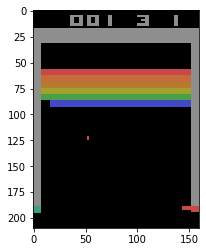

In [7]:
# oserve our agent in action
# probably notebook is not the best enviroment now
# reward is actually collected from listener global_reward that waits for a space to be pressed

# with a custom randomized policy our model does not give any suffisient behaviour 
# that what we need: a broken agent that would recover with our human reward

#%matplotlib notebook
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


import time
n_frames = 100
obs = env.reset()

for _ in range(n_frames):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    ax.imshow(env.venv.render(mode='rgb_array'))
    display(fig)
    clear_output(wait=True)
    # print("Action:", action, "Reward:", rewards, "Done:", dones)
    time.sleep(0.01)
env.close()
print('fin')



## Generating TensorBoard files

In [30]:
model = DQN(CnnPolicy, env, verbose=2, double_q=True)

file = open('BreakoutNoFrameskip-v4.pkl', 'rb')
model_dict, model_weights = pickle.load(file)
model.load_parameters(model_weights)

with model.sess as sess:
    writer = tf.summary.FileWriter("tensor_files", sess.graph)
    sess.run(model.sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='deepq')[-1])
    writer.close()

After generating files, you should have a directory in your project called ```tensor_files```. In order to load ```tensor_files``` run the following command ```tensorboard --logdir=tensor_files``` in the same directory